# | Practice 3-2 | Transfer Learning

**Pre-trained Model**은 ImageNet과 같은 대규모(Large-scale) 데이터셋에서 학습 후 저장된 네트워크로, 일반적으로 대규모 Image classification task에서 학습된 것이다. <br>
학습된 모델은 그대로 사용하거나, **Transfer Learning**을 이용하여 새로운 task에 사용할 수 있다. <br>

이번 실습에서는 ***MobileNetV2*** 구조로 **ImageNet 데이터셋에 학습한 Pre-trained Model을 활용**하여 **Transfer Learning으로 개와 고양이를 분류**하는 모델을 만든다. 

---

## (Optional) Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/ColabNotebooks/ColabNotebooks'

/content/drive/MyDrive/ColabNotebooks/ColabNotebooks


## Import Modules

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## GPU Setting

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpu_growth = False

if gpu_growth:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass

---

## 0. Dataset : Cats and Dogs

### (1) Download Dataset

`tf.keras.utils.get_file` 을 이용하여 데이터를 다운로드한다. <br>
- `fname`: 파일 이름. 절대경로가 지정되면 해당 위치에 파일이 저장됨
- `origin`: 파일을 받아오는 경로
- `extract`: True로 설정하면 tar 또는 zip과 같은 파일을 아카이브로 추출하려고 시도함

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file(fname='cats_and_dogs.zip', 
                                      origin=_URL, 
                                      extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

print(path_to_zip)
print(PATH)

68616192/68606236 [==============================] - 0s 0us/step
/root/.keras/datasets/cats_and_dogs.zip
/root/.keras/datasets/cats_and_dogs_filtered


### (2) Create Train / Valid / Test Dataset

**Train / Valid**

`tf.keras.preprocessing.image_dataset_from_directory`를 이용하여 training / validation 을 위한 `tf.data.Dataset`을 생성한다. <br>
(디렉토리 내의 이미지 파일들로부터 `tf.data.Dataset`을 생성)

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# train dataset
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
# valid dataset
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


`as_numpy_iterator` 메소드는 Dataset의 모든 요소를 numpy로 변환하는 iterator를 리턴하는데, 이것을 리스트에 담아서 데이터셋을 출력해볼 수 있다.

In [ ]:
dataset_list = list(train_dataset.as_numpy_iterator())
print(len(dataset_list))
print(f"images: {dataset_list[0][0].shape}")
print(f"labels: {dataset_list[0][1].shape}")

63
images: (32, 160, 160, 3)
labels: (32,)


**Test**

원본 데이터셋에는 test 데이터셋이 포함되어있지 않으므로 **valid 데이터셋의 20%를 test 데이터셋**으로 만든다.<br>
`tf.data.experimental.cardinality`는 데이터셋의 batch size를 반환하는데, 32배치의 데이터셋을 5등분하고 올림하여 6개의 배치를 test 데이터셋으로 만든다.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### (3) Data Visualization

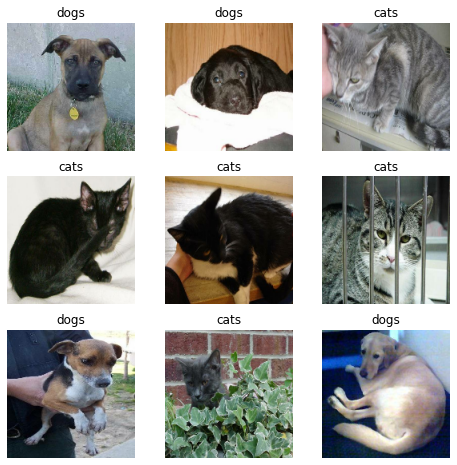

In [ ]:
class_names = train_dataset.class_names # ['cats', 'dogs']

plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for images, labels in train_dataset.take(1):
    print(len(labels))
    print(labels)

32
tf.Tensor([0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1], shape=(32,), dtype=int32)


---

## 1. Data Preprocessing

### (1) Prefetching (Configure the dataset for performance)

Prefetching은 데이터 전처리와 학습 과정을 오버랩한다. 즉, 데이터가 소비되는 시간과 데이터가 생성되는 시간 사이의 의존성을 줄인다. (데이터 요청 시간 전에 데이터셋에서 데이터를 가져와 메모리에 올려둠) <br>
- 가져올 데이터 수는 한 training step에서 소비하는 배치의 수와 같거나 커야한다.
- `AUTOTUNE`을 사용하면 데이터를 고정적인 크기로 미리 가져와 메모리에 올려놓는것이 아니라 자원 현황에 따라 적절히 동적으로 값을 조정한다.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### (2) Data Augmentation

데이터셋 크기가 작은경우 training 데이터셋에 Rotation, Flip등을 무작위로 적용하여 **샘플의 다양성**을 인위적으로 도입하면 과대적합(over fitting)을 줄일 수 있다. <br>
`tf.keras.layers.experimental.preprocessing`을 이용한다. <br>

***참고*** ) `model.fit` 을 호출할 때 학습중에만 data augmentation 레이어가 활성화되고, `model.evaulate`에서는 비활성화된다.

In [ ]:
data_augmentation = tf.keras.Sequential([
                    ####### 실습 #######
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                    ###################
                    ])

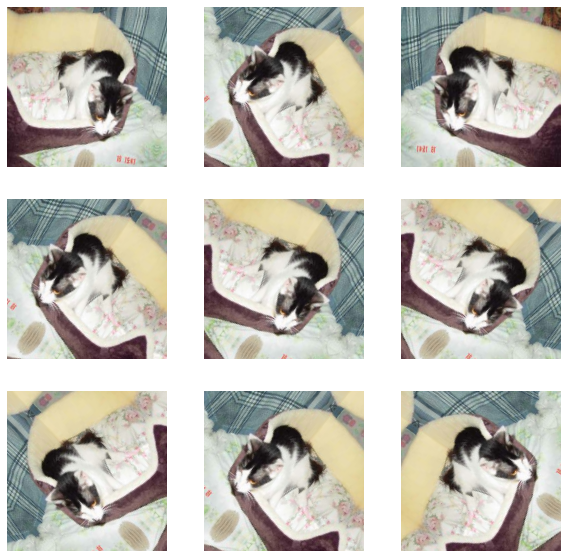

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### (3) Rescaling Pixel Values

이번 실습에서는 Tensorflow에서 제공해주는 MobileNetV2 모델, `tf.keras.applications.MobileNetV2`을 이용하는데, **이 모델의 input은 [0, 255] 픽셀값이 아닌 [-1, 1] 값을 사용**한다. <br>

`tf.keras.applications.mobilenet_v2.preprocess_input`을 이용하면 모델에 맞춰 쉽게 preprocessing할 수 있다. <br>

또는 `tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)`을 이용하여 rescaling해도 된다.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

---

## 2. Model

### (1) Base Model from the pre-trained convnets

ImageNet데이터로 학습된 MobileNetV2 모델을 생성한다.
- `input_shape`은 (160, 160, 3)으로 한다.
- `include_top=False`로 설정하면 이미지 **feature extractor**만 가져오고 **classifier**는 가져오지 않는다.
- `weights=imagenet`으로 설정하여 **ImageNet pre-trained model**을 가져올 수 있다.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
####### 실습 #######
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
###################

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

**Base model**에 데이터를 넣어 forward propagation 시킨 후 결과의 shape을 보면 (32, 5, 5, 1280) 으로, 32배치 데이터에 대해서 1280필터가 출력한 5x5 ***feature map***이 나온다.


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### (2) Feature Extraction (Freeze the convolutional base)

**Base Model**은 잘 학습된 것이므로 **freeze**하여 새로 학습할 때 weights가 업데이트되지 않도록 해준다. 즉, 사전 학습된 정보가 손상되지 않도록 한다.

In [ ]:
####### 실습 #######
base_model.trainable = False
###################

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### (3) Custom Classifier (Classification Head)

개 / 고양이 분류를 할 수 있는 **binary classifier**를 새롭게 추가한다.

정답 레이블이 고양이(0) 또는 개(1) 이므로, 최종적으로 **'개인지 아닌지'**만 판단해도 된다. <br>
따라서 최종적으로 **1개 노드의 class 출력 레이어**를 만들것이다. (positive는 1, negative는 0인 logit을 출력)

In [ ]:
print(f"feature_batch shape: {feature_batch.shape}")
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(f"feature_batch_average shape: {feature_batch_average.shape}")

feature_batch shape: (32, 5, 5, 1280)
feature_batch_average shape: (32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


CNN model에는 `tf.keras.layers.BatchNormalization` (BN layer)가 포함되어있는데, base model을 불러올 때 `training = False`로 설정하여 BN layer를 inference mode로 유지해야한다. <br>

BN layer에는 학습 중 업데이트되는 학습 불가능한(input의 mean, variance 추적하는) 2개의 weights가 있는데, inference mode에서 실행해야 mean, variance 통계가 업데이트되지 않는다. 그렇지 않으면 학습 불가능한 weights에 적용된 업데이트로 인해 모델이 학습한 내용이 갑작스럽게 파괴될 수 있다.

In [ ]:
'''
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers 
* Use the Keras Functional API
'''
inputs = tf.keras.Input(shape=(160, 160, 3))
####### 실습 #######
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
###################
model = tf.keras.Model(inputs, outputs)

---

## 3. Model Compile & Training

### (1) Model Compile

- learning rate: 0.0001
- optimizer: RMSprop
- loss: binary cross entropy
- metrics: 'accuracy'

In [ ]:
####### 실습 #######
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
###################

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[-0.00996974],
        [-0.02886891],
        [-0.04239773],
        ...,
        [ 0.02093784],
        [ 0.02189297],
        [ 0.06843071]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### (2) Train

**Evaluation before training**

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_dataset)

6/6 [==============================] - 3s 36ms/step - loss: 0.8184 - accuracy: 0.4583


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.46


**Training & Evaluation** <br>

`model.fit`을 하면, base model부분은 고정되어있으므로 **Custom classifier** 부분만 학습된다.

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 69ms/step - loss: 0.7220 - accuracy: 0.5755 - val_loss: 0.5383 - val_accuracy: 0.6733
Epoch 2/10
63/63 [==============================] - 4s 62ms/step - loss: 0.5318 - accuracy: 0.7010 - val_loss: 0.3758 - val_accuracy: 0.7995
Epoch 3/10
63/63 [==============================] - 4s 60ms/step - loss: 0.4140 - accuracy: 0.7850 - val_loss: 0.2772 - val_accuracy: 0.8837
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3378 - accuracy: 0.8440 - val_loss: 0.2224 - val_accuracy: 0.9146
Epoch 5/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2833 - accuracy: 0.8690 - val_loss: 0.1809 - val_accuracy: 0.9455
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2550 - accuracy: 0.8875 - val_loss: 0.1520 - val_accuracy: 0.9567
Epoch 7/10
63/63 [==============================] - 4s 59ms/step - loss: 0.2323 - accuracy: 0.8930 - val_loss: 0.1323 - val_accuracy: 0.9567
Epoch 8/10
63

**Learning Curves**

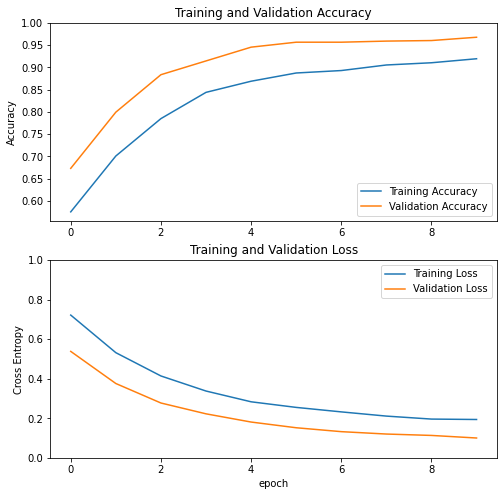

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_dataset)

6/6 [==============================] - 1s 46ms/step - loss: 0.1028 - accuracy: 0.9583


[0.10284843295812607, 0.9583333134651184]

---

## 4. Fine Tuning

Pre-trained base model의 일부 freeze를 해제하고, 낮은 learning rate로 전체 모델을 재학습시키는 **Fine Tuning**을 할 수 있다. 이를 통해 feature map이 새로운 데이터셋에 맞춰 조정되어 모델의 성능이 향상될 수 있다. <br>

***Note***: 최상위 classifier를 학습한 뒤 시도해야한다. 만약 Pre-trained base model에 무작위로 초기화(randomly initialized)된 classifier를 추가하고 freeze를 해제한 뒤 학습하면 gradient update가 너무 커지고, pre-train한 것의 의미가 사라진다.

### (1) Un-freeze the top layers of the model

소수의 Top layer를 fine tuning한다. 이를 위해 base model의 freeze를 해제하고 bottom-layer를 un-trainable로 설정한다.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
####### 실습 #######
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False
###################
        
print("Number of trainable layers in the base model: ", len(base_model.trainable_variables))

Number of layers in the base model:  154
Number of trainable layers in the base model:  54


### (2) Compile the model

In [ ]:
####### 실습 #######
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
###################

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### (3) Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 11s 79ms/step - loss: 0.1595 - accuracy: 0.9335 - val_loss: 0.0546 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 6s 84ms/step - loss: 0.1193 - accuracy: 0.9525 - val_loss: 0.0564 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 4s 66ms/step - loss: 0.1109 - accuracy: 0.9550 - val_loss: 0.0563 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0780 - accuracy: 0.9710 - val_loss: 0.0417 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0954 - accuracy: 0.9615 - val_loss: 0.0379 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 6s 90ms/step - loss: 0.0824 - accuracy: 0.9630 - val_loss: 0.0393 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 4s 66ms/step - loss: 0.0790 - accuracy: 0.9685 - val_loss: 0.0395 - val_accuracy: 0.9839
Epoch

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

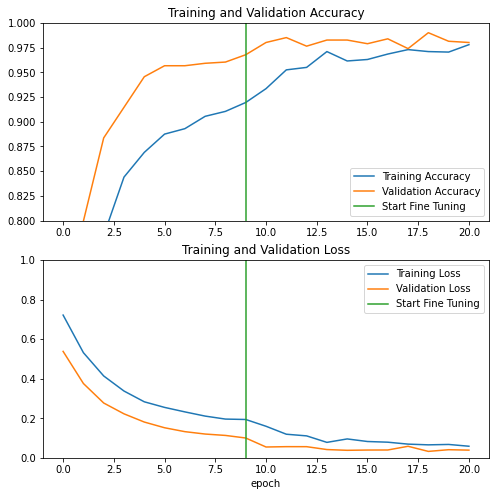

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### (4) Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 109ms/step - loss: 0.0291 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions:
 [0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1]
Labels:
 [0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1]


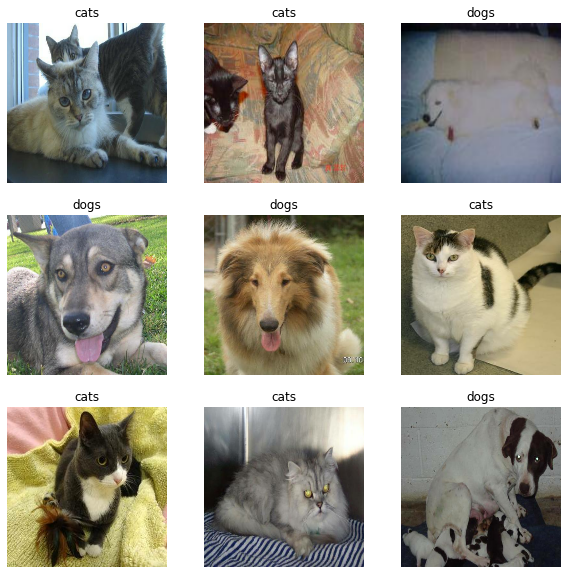

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")